This is my "sandbox" to play around with the BEA api. My plan is to use this for my regional cycle project. Below I explain how to use the BEA api (stuff has changed since I last messed around with it)

In [34]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import weightedcalcs as wc
import os
import geopandas as gpd # this is the main geopandas 

In [2]:
BEA_ID = "6BF79D8C-8042-4196-88DC-0E0C55B0C3B6"

After getting your key. [Here is some basic documentation](https://www.bea.gov/API/bea_web_service_api_user_guide.htm). Like a lot APIs, basic idea is to specify the URL in the proper way and it will return some output in a specified format. We can then convert the format (its .json) into a dataframe:



In [3]:
API_URL = "https://bea.gov/api/data?&"
API_URL = API_URL + "UserID=" + BEA_ID + "&method=GETDATASETLIST&ResultFormat=JSON&"
    
r = requests.get(API_URL)

In [6]:
print(r.json().keys())

print(r.json()['BEAAPI'].keys())

print(r.json()['BEAAPI']["Results"].keys())

dict_keys(['BEAAPI'])
dict_keys(['Request', 'Results'])
dict_keys(['Dataset'])


This then leads to the insight that the `.json()` is a bunch of dictionaries within the dictionaries and that by working through it we can find a "root dictionary" that can be converted into a usable DataFrame

In [7]:
df = pd.DataFrame(r.json()["BEAAPI"]["Results"]['Dataset'])

In [8]:
df

,DatasetDescription,DatasetName
0,The RegionalData dataset is obsolete. Please u...,RegionalData
1,Standard NIPA tables,NIPA
2,Standard NI underlying detail tables,NIUnderlyingDetail
3,Multinational Enterprises,MNE
4,Standard Fixed Assets tables,FixedAssets
5,International Transactions Accounts,ITA
6,International Investment Position,IIP
7,GDP by Industry,GDPbyIndustry
8,Regional Income data sets,RegionalIncome
9,Regional Product data sets,RegionalProduct


Then this gives us the different datasets that are available through the BEA api. Now below, I'm going to grab personal income at the county level. The documentation for grabing this is [here](https://www.bea.gov/API/bea_web_service_api_user_guide.htm)

This is how to find out the lines for individual tables. Table CA4 is of interest as it has the break down of personal income by types.

In [82]:
my_key = "https://bea.gov/api/data?&UserID=" + BEA_ID + "&"

data_set = "datasetname=RegionalIncome&"

method = "method=GetParameterValuesFiltered&"

dataset = "datasetname=RegionalIncome&"

linecode = "TargetParameter=LineCode&"

tablename = "TableName=CA4&"

location = "GeoFips=COUNTY&"

form = "ResultFormat=json"

API_URL = my_key + method + dataset + linecode + tablename + form

r = requests.get(API_URL)

r.json()["BEAAPI"]["Results"]


{'ParamValue': [{'Desc': '[CA4] Personal income', 'Key': '10'},
  {'Desc': '[CA4] Nonfarm personal income', 'Key': '11'},
  {'Desc': '[CA4] Farm income', 'Key': '12'},
  {'Desc': '[CA4] Population', 'Key': '20'},
  {'Desc': '[CA4] Per capita personal income', 'Key': '30'},
  {'Desc': '[CA4] Earnings by place of work', 'Key': '35'},
  {'Desc': '[CA4] Contributions for government social insurance', 'Key': '36'},
  {'Desc': '[CA4] Employee and self-employed contributions for government social insurance',
   'Key': '37'},
  {'Desc': '[CA4] Employer contributions for government social insurance',
   'Key': '38'},
  {'Desc': '[CA4] Adjustment for residence', 'Key': '42'},
  {'Desc': '[CA4] Net earnings by place of residence', 'Key': '45'},
  {'Desc': '[CA4] Dividends, interest, and rent', 'Key': '46'},
  {'Desc': '[CA4] Personal current transfer receipts', 'Key': '47'},
  {'Desc': '[CA4] Wages and salaries', 'Key': '50'},
  {'Desc': '[CA4] Supplements to wages and salaries', 'Key': '60'},
  

This then grabs the some of it as a deomonstration

In [68]:
my_key = "https://bea.gov/api/data?&UserID=" + BEA_ID + "&method=GetData&"

data_set = "datasetname=RegionalIncome&"

table_and_line_wages = "TableName=CA4&LineCode=010&"

year = "Year=" + "2000" + "&"

location = "GeoFips=COUNTY&"

form = "ResultFormat=json"

API_URL = my_key + data_set + table_and_line_wages + year + location + form

r = requests.get(API_URL)

df_income = pd.DataFrame(r.json()["BEAAPI"]["Results"]["Data"])

In [83]:
df_income.head()

,CL_UNIT,Code,DataValue,GeoFips,GeoName,NoteRef,TimePeriod,UNIT_MULT
0,thousands of dollars,CA4-10,8634847000,00000,United States,NaN,2000,3
1,thousands of dollars,CA4-10,108000944,01000,Alabama,NaN,2000,3
2,thousands of dollars,CA4-10,1036129,01001,"Autauga, AL",NaN,2000,3
3,thousands of dollars,CA4-10,3770707,01003,"Baldwin, AL",NaN,2000,3
4,thousands of dollars,CA4-10,547871,01005,"Barbour, AL",NaN,2000,3


---

Now what I want to do is to (for all years possible), grab the [personal per capital income](https://www.bea.gov/regional/#defs) and the population measure at the country level. There are several steps here. First, I construct a string of all the years I want. Then I pass the appropriate URL to the BEA. This took some time to figure this all out.

In [6]:
years = range(1969,2018)
years = list(years)

years = "".join(str(years))

years = years[1:-1]

In [7]:
years

'1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017'

This then grabs the per capita personal income data:

In [8]:
my_key = "https://bea.gov/api/data?&UserID=" + BEA_ID + "&method=GetData&"

data_set = "datasetname=RegionalIncome&"

table_and_line_income = "TableName=CA1&LineCode=3&"

table_and_line_population = "TableName=CA1&LineCode=2&"

year = "Year=" + years + "&"

location = "GeoFips=COUNTY&"

form = "ResultFormat=json"

In [9]:
API_URL = my_key + data_set + table_and_line_income + year + location + form

r = requests.get(API_URL)

df_income = pd.DataFrame(r.json()["BEAAPI"]["Results"]["Data"])

In [10]:
df_income.head(15)

,CL_UNIT,Code,DataValue,GeoFips,GeoName,NoteRef,TimePeriod,UNIT_MULT
0,dollars,CA1-3,4196,00000,United States,NaN,1970,0
1,dollars,CA1-3,8338,00000,United States,NaN,1978,0
2,dollars,CA1-3,21698,00000,United States,NaN,1993,0
3,dollars,CA1-3,40277,00000,United States,NaN,2010,0
4,dollars,CA1-3,13860,00000,United States,NaN,1984,0
5,dollars,CA1-3,18653,00000,United States,NaN,1989,0
6,dollars,CA1-3,5352,00000,United States,NaN,1973,0
7,dollars,CA1-3,15459,00000,United States,NaN,1986,0
8,dollars,CA1-3,11262,00000,United States,NaN,1981,0
9,dollars,CA1-3,6856,00000,United States,NaN,1976,0


In [11]:
df_income.drop(['CL_UNIT', 'Code',"NoteRef", "UNIT_MULT"], axis=1, inplace = True)

#df["DataValue"].column = "IncomePC"

df_income.rename(columns={"DataValue":"IncomePC"}, inplace=True)

df_income.head()

,IncomePC,GeoFips,GeoName,TimePeriod
0,4196,00000,United States,1970
1,8338,00000,United States,1978
2,21698,00000,United States,1993
3,40277,00000,United States,2010
4,13860,00000,United States,1984


In [12]:
API_URL = my_key + data_set + table_and_line_population + year + location + form

r = requests.get(API_URL)

population = pd.DataFrame(r.json()["BEAAPI"]["Results"]["Data"])

population.drop(['CL_UNIT', 'Code',"NoteRef", "UNIT_MULT", "GeoName"], axis=1, inplace = True)

#df["DataValue"].column = "IncomePC"

population.rename(columns={"DataValue":"Population"}, inplace=True)

population.head()

,Population,GeoFips,TimePeriod
0,244499004,00000,1988
1,292805298,00000,2004
2,240132831,00000,1986
3,287625193,00000,2002
4,290107933,00000,2003


In [13]:
combo = pd.merge(population, df_income,   # left df, right df
                 how='inner',      # Try the different options, inner, outer, left, right...what happens.
                 on=['GeoFips',"TimePeriod"],       # link with cntry
                 indicator=True)  # Tells us what happend

In [14]:
combo["TimePeriod"] = pd.to_datetime(combo["TimePeriod"], infer_datetime_format = True)

#combo.sort_values(by = "TimePeriod", inplace = True)

In [15]:
combo["county_fips"] = combo["GeoFips"].str[2:]
combo["state_fips"] = combo["GeoFips"].str[0:2]

In [16]:
combo.head()

,Population,GeoFips,TimePeriod,IncomePC,GeoName,_merge,county_fips,state_fips
0,244499004,00000,1988-01-01,17426,United States,both,000,00
1,292805298,00000,2004-01-01,34316,United States,both,000,00
2,240132831,00000,1986-01-01,15459,United States,both,000,00
3,287625193,00000,2002-01-01,31815,United States,both,000,00
4,290107933,00000,2003-01-01,32692,United States,both,000,00


In [18]:
combo = combo[combo.county_fips != "000"]

In [19]:
combo.set_index(["county_fips","TimePeriod"],inplace = True)

In [20]:
combo.sort_index(level="county_fips", inplace = True)

In [21]:
combo.index.shape

(150624,)

In [22]:
combo.Population.replace("(NA)", np.nan, inplace = True)
combo.Population = combo.Population.astype(float)

In [23]:
combo.IncomePC.replace("(NA)", np.nan, inplace = True)
combo.IncomePC = combo.IncomePC.astype(float)

In [24]:
combo.head()

Population GeoFips  IncomePC       GeoName _merge  \
county_fips TimePeriod                                                      
001         1969-01-01     25166.0   01001    2774.0   Autauga, AL   both   
            1969-01-01     34200.0   04001    2353.0    Apache, AZ   both   
            1969-01-01     23393.0   05001    3122.0  Arkansas, AR   both   
            1969-01-01   1060099.0   06001    4712.0   Alameda, CA   both   
            1969-01-01    182656.0   08001    3527.0    Adams, CO*   both   

                       state_fips  
county_fips TimePeriod             
001         1969-01-01         01  
            1969-01-01         04  
            1969-01-01         05  
            1969-01-01         06  
            1969-01-01         08

In [136]:
combo.dropna(inplace=True)
grp = combo.groupby(["TimePeriod"])

In [109]:
calc = wc.Calculator("Population")

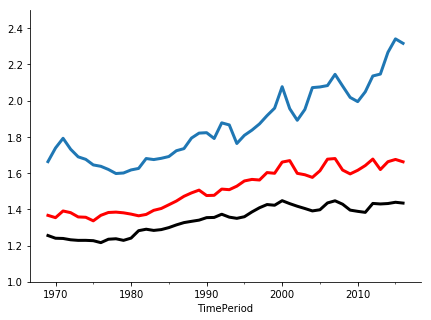

In [142]:
rich_poor_99 = (calc.quantile(grp, "IncomePC", 0.99)/calc.quantile(grp, "IncomePC", 0.50))
rich_poor_95 = (calc.quantile(grp, "IncomePC", 0.95)/calc.quantile(grp, "IncomePC", 0.50))
rich_poor_90 = (calc.quantile(grp, "IncomePC", 0.90)/calc.quantile(grp, "IncomePC", 0.50))

fig, ax  = plt.subplots()

rich_poor_99.plot(ax = ax, lw = 3, figsize = (7,5))

rich_poor_95.plot(ax = ax, lw = 3, color = "red")

rich_poor_90.plot(ax = ax, lw = 3, color = "black")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylim(1.0,2.5)

plt.show()

In [173]:
year1 = "1969-01-01"
year2 = "1980-01-01"

us_counties69 = combo.xs(year1, level='TimePeriod').dropna()

us_counties69.rename(columns = {"IncomePC": "IncomePC"+ year1}, inplace=True)

mean69 = calc.median(us_counties69, "IncomePC"+ year1)

us_counties15 = combo.xs(year2, level='TimePeriod').dropna()

us_counties15.rename(columns = {"IncomePC": "IncomePC"+ year2}, inplace=True)

mean15 = calc.median(us_counties15, "IncomePC"+ year2)

In [174]:
print(mean15)

print(mean69)

10041.0
3892.0


In [175]:
cwd = os.getcwd()

regions_shape = '''C:\\data_bootcamp\\data_bootcamp_spring_2018\\week13\\shape_files\\UScounties\\cb_2017_us_county_500k.shx'''

In [176]:
regions_shape

'C:\\data_bootcamp\\data_bootcamp_spring_2018\\week13\\shape_files\\UScounties\\cb_2017_us_county_500k.shx'

In [177]:
us_map = gpd.read_file(regions_shape)

In [178]:
us_map.head()

us_map["GeoFips"] = us_map["STATEFP"] + us_map["COUNTYFP"]

us_map.set_index("STATEFP", inplace = True)

us_map.drop(["02","03","15","43","14","79","78","72","69","60","66"], inplace = True)

In [179]:
us_counties69.columns

Index(['Population', 'GeoFips', 'IncomePC1969-01-01', 'GeoName', '_merge',
       'state_fips'],
      dtype='object')

In [180]:
us_map  = us_map.merge(us_counties69, on='GeoFips', how = "left")

us_map  = us_map.merge(us_counties15, on='GeoFips', how = "left")

us_map.head()


,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,GeoFips,Population_x,IncomePC1969-01-01,GeoName_x,_merge_x,state_fips_x,Population_y,IncomePC1980-01-01,GeoName_y,_merge_y,state_fips_y
0,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74...",01005,23818.0,2143.0,"Barbour, AL",both,01,24763.0,6414.0,"Barbour, AL",both,01
1,023,00161537,0500000US01023,01023,Choctaw,06,2365869837,19144469,"POLYGON ((-88.47322699999999 31.893856, -88.46...",01023,18432.0,1597.0,"Choctaw, AL",both,01,16812.0,5499.0,"Choctaw, AL",both,01
2,035,00161543,0500000US01035,01035,Conecuh,06,2201948618,6643480,"POLYGON ((-87.42720399999999 31.26436, -87.425...",01035,16645.0,1811.0,"Conecuh, AL",both,01,15838.0,6286.0,"Conecuh, AL",both,01
3,051,00161551,0500000US01051,01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.41333499999999 32.750591, -86.37...",01051,32941.0,2599.0,"Elmore, AL",both,01,43474.0,7825.0,"Elmore, AL",both,01
4,065,00161558,0500000US01065,01065,Hale,06,1667907107,32423356,"POLYGON ((-87.870464 32.762442, -87.868184 32....",01065,18512.0,1487.0,"Hale, AL",both,01,15602.0,4778.0,"Hale, AL",both,01


In [181]:
us_map["log_income"+ year1] = np.log(us_map["IncomePC"+ year1] / mean69) 

us_map["log_income"+ year2] = np.log(us_map["IncomePC"+ year2] / mean15) 

us_map.head()

,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,GeoFips,...,GeoName_x,_merge_x,state_fips_x,Population_y,IncomePC1980-01-01,GeoName_y,_merge_y,state_fips_y,log_income1969-01-01,log_income1980-01-01
0,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74...",01005,...,"Barbour, AL",both,01,24763.0,6414.0,"Barbour, AL",both,01,-0.596716,-0.448194
1,023,00161537,0500000US01023,01023,Choctaw,06,2365869837,19144469,"POLYGON ((-88.47322699999999 31.893856, -88.46...",01023,...,"Choctaw, AL",both,01,16812.0,5499.0,"Choctaw, AL",both,01,-0.890796,-0.602110
2,035,00161543,0500000US01035,01035,Conecuh,06,2201948618,6643480,"POLYGON ((-87.42720399999999 31.26436, -87.425...",01035,...,"Conecuh, AL",both,01,15838.0,6286.0,"Conecuh, AL",both,01,-0.765044,-0.468352
3,051,00161551,0500000US01051,01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.41333499999999 32.750591, -86.37...",01051,...,"Elmore, AL",both,01,43474.0,7825.0,"Elmore, AL",both,01,-0.403796,-0.249353
4,065,00161558,0500000US01065,01065,Hale,06,1667907107,32423356,"POLYGON ((-87.870464 32.762442, -87.868184 32....",01065,...,"Hale, AL",both,01,15602.0,4778.0,"Hale, AL",both,01,-0.962162,-0.742655


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


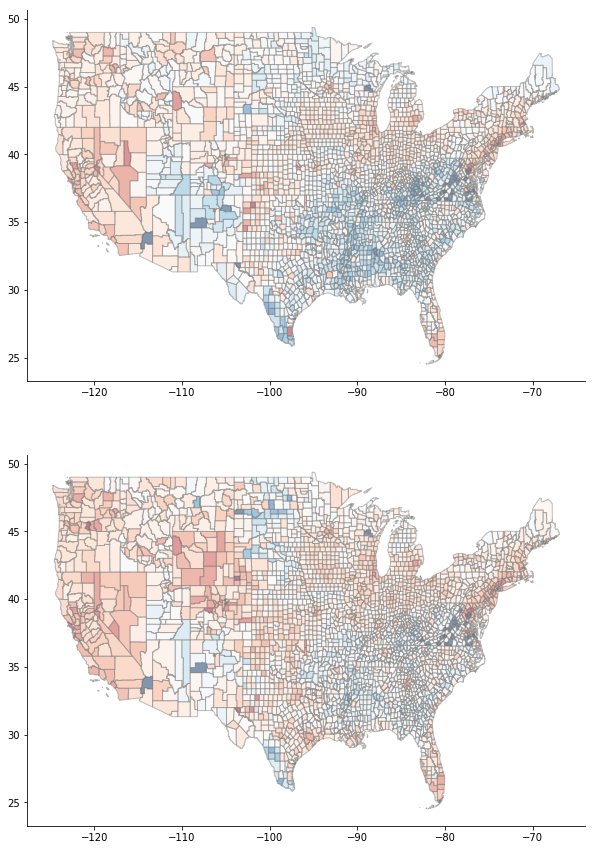

In [182]:
fig, ax = plt.subplots(2,1, figsize = (10,15))

# First create the map for the urban share

us_map.plot(ax = ax[0], edgecolor='tab:grey', column="log_income"+ year1, cmap='RdBu_r', alpha = 0.5)



us_map.plot(ax = ax[1], edgecolor='tab:grey', column="log_income"+ year2, cmap='RdBu_r', alpha = 0.5)

ax_length = range(0,2)

for var in ax_length:
    ax[var].spines["right"].set_visible(False)
    ax[var].spines["top"].set_visible(False)


###################################################

plt.show()

---

In [68]:
us_map.head()

,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,GeoFips,...,_merge_x,state_fips_x,Population_y,IncomePC_y,GeoName_y,_merge_y,state_fips_y,log_income,log_income_y,log_income_x
0,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74...",01005,...,both,01,26270.0,31635.0,"Barbour, AL",both,01,-0.245011,-0.245011,-0.365865
1,023,00161537,0500000US01023,01023,Choctaw,06,2365869837,19144469,"POLYGON ((-88.47322699999999 31.893856, -88.46...",01023,...,both,01,13201.0,30787.0,"Choctaw, AL",both,01,-0.272182,-0.272182,-0.659945
2,035,00161543,0500000US01035,01035,Conecuh,06,2201948618,6643480,"POLYGON ((-87.42720399999999 31.26436, -87.425...",01035,...,both,01,12597.0,29644.0,"Conecuh, AL",both,01,-0.310015,-0.310015,-0.534193
3,051,00161551,0500000US01051,01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.41333499999999 32.750591, -86.37...",01051,...,both,01,81238.0,38126.0,"Elmore, AL",both,01,-0.058379,-0.058379,-0.172945
4,065,00161558,0500000US01065,01065,Hale,06,1667907107,32423356,"POLYGON ((-87.870464 32.762442, -87.868184 32....",01065,...,both,01,15075.0,35138.0,"Hale, AL",both,01,-0.139992,-0.139992,-0.731311


In [290]:
df.dtypes

CL_UNIT        object
Code           object
DataValue     float64
GeoFips        object
GeoName        object
NoteRef        object
TimePeriod     object
UNIT_MULT      object
dtype: object

In [291]:
df["TimePeriod"] = pd.to_datetime(df["TimePeriod"], infer_datetime_format = True)

In [292]:
df.sort_values(by = "TimePeriod", inplace = True)


In [294]:
df.head()

,CL_UNIT,Code,DataValue,GeoFips,GeoName,NoteRef,TimePeriod,UNIT_MULT
0,dollars,CA1-3,3930.0,00000,United States,NaN,1969-01-01,0
3535,dollars,CA1-3,2800.0,31123,"Morrill, NE",NaN,1969-01-01,0
3536,dollars,CA1-3,3093.0,31125,"Nance, NE",NaN,1969-01-01,0
3539,dollars,CA1-3,3727.0,31127,"Nemaha, NE",NaN,1969-01-01,0
3540,dollars,CA1-3,3106.0,31129,"Nuckolls, NE",NaN,1969-01-01,0


In [346]:
grp = df.groupby("GeoFips")

In [310]:
def log_diff_income(df):
    df["growth"] = np.log(df.DataValue).diff() / 46
    
    return df

In [388]:
transform_dict = {"DataValue": ["first","last", lambda x: np.diff(np.log(x))/46]}

new_df = grp.agg(transform_dict)

In [394]:
new_df["DataValue"]["last"].corr(new_df["DataValue"]["<lambda>"])

0.414791642511866

In [367]:
test =  new_df.diff(axis = 1).toseries

AttributeError: 'DataFrame' object has no attribute 'toseries'

In [385]:
np.diff?

In [309]:
grp = df.groupby("GeoFips")
grp.get_group("44007").TimePeriod.diff()

Object `TimePeriod.diff` not found.


In [ ]:
grp.get_group("44007").TimePeriod.diff

In [ ]:
grp.get_group("44007").sort_value

In [ ]:
grp.get_group("44007").sort_values

In [277]:
new_df.sort_values?

In [332]:
new_df.growth.corr(new_df.loc["1969-01-01"].DataValue)

nan

In [325]:
new_df.set_index("TimePeriod", inplace = True)

In [376]:
df.diff?